In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("taxi_2023_clean.csv")
print(df.head())
print(df.shape)

  taxi_type          PU_datetime  PU_month  PU_day  PU_hour PU_day_of_week  \
0    yellow  2023-03-07 14:07:12         3       7       14        Tuesday   
1    yellow  2023-03-07 14:37:50         3       7       14        Tuesday   
2    yellow  2023-03-07 14:57:46         3       7       14        Tuesday   
3    yellow  2023-03-07 18:30:17         3       7       18        Tuesday   
4    yellow  2023-03-07 20:28:25         3       7       20        Tuesday   

           DO_datetime  DO_month  DO_day  DO_hour  ...  \
0  2023-03-07 14:26:47         3       7       14  ...   
1  2023-03-07 14:42:11         3       7       14  ...   
2  2023-03-07 15:09:36         3       7       15  ...   
3  2023-03-07 19:00:21         3       7       19  ...   
4  2023-03-07 21:09:20         3       7       21  ...   

                     DO_zone  trip_distance fare_amount tip_amount  \
0  Times Sq/Theatre District           1.44        17.0       4.40   
1              Midtown North           0.7

In [3]:
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 50)]
df = df[df['fare_amount'] > 0]
print(df.shape)

(21005543, 26)


In [4]:
# Map for taxi_type
taxi_map = {'yellow': 1, 'green': 2, 'Uber': 3, 'Lyft': 4}
df['taxi_type'] = df['taxi_type'].map(taxi_map)

# Map for day of week
day_map = {
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
    'Friday': 5, 'Saturday': 6, 'Sunday': 7
}
df['PU_day_of_week'] = df['PU_day_of_week'].map(day_map)
df['DO_day_of_week'] = df['DO_day_of_week'].map(day_map)


In [5]:
df['PU_datetime'] = pd.to_datetime(df['PU_datetime'])
df['DO_datetime'] = pd.to_datetime(df['DO_datetime'])

df['trip_duration'] = (df['DO_datetime'] - df['PU_datetime']).dt.total_seconds() / 60
df['day_night'] = df['PU_hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)
df['fare_per_mile'] = df['fare_amount'] / df['trip_distance']
df['income_gap'] = df['PU_income_quartile'] - df['DO_income_quartile']
df['tipped'] = (df['tip_amount'] > 0).astype(int)

In [7]:
df['fare_distance_interaction'] = df['fare_amount'] * df['trip_distance']
df['income_interaction'] = df['PU_income_quartile'] * df['DO_income_quartile']

In [8]:
#df = df[df['tip_percentage'] <= 100]
over_100_df =  df[df['tip_percentage'] > 100]

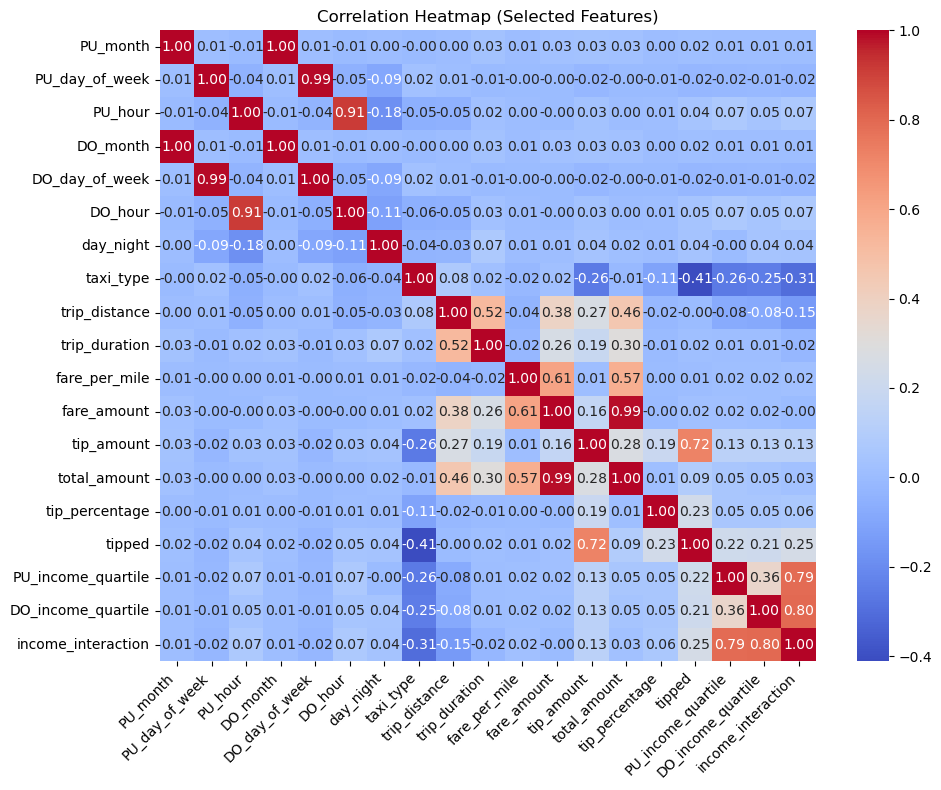

In [15]:
selected_columns = [
    'PU_month','PU_day_of_week', 'PU_hour', 'DO_month', 'DO_day_of_week', 'DO_hour', 'day_night',
    'taxi_type', 'trip_distance', 'trip_duration', 'fare_per_mile', 'fare_amount', 'tip_amount', 'total_amount', 'tip_percentage', 'tipped', 
    'PU_income_quartile', 'DO_income_quartile', 'income_interaction'
]

subset_df = df[selected_columns]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Selected Features)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


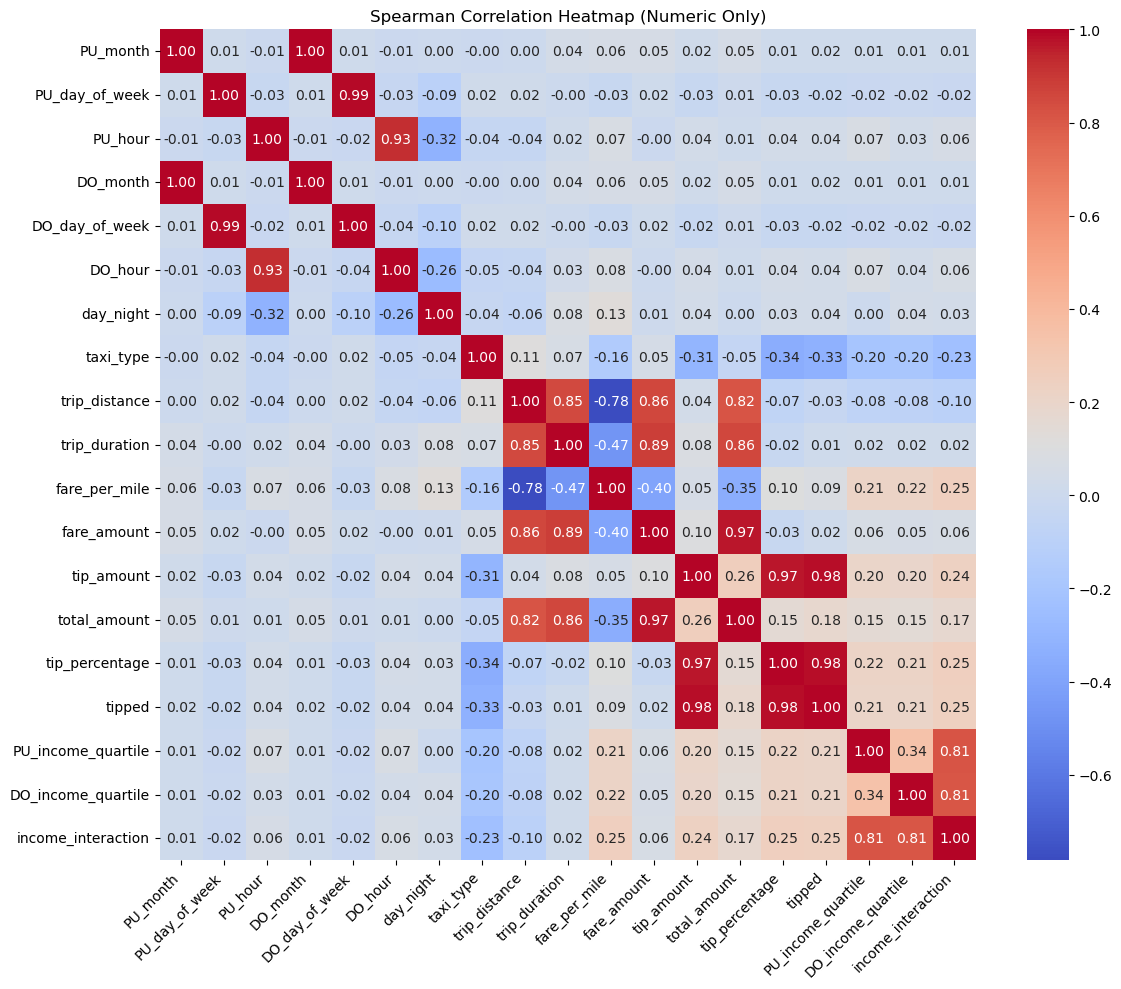

In [17]:
# Compute Spearman correlation
spearman_corr = subset_df.corr(method='spearman')


plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Spearman Correlation Heatmap (Numeric Only)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [19]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer, root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Features and target
X = df[['PU_month', 'PU_day_of_week', 'DO_month', 'PU_hour', 'DO_day_of_week', 'DO_hour', 'taxi_type', 'PU_income_quartile', 'DO_income_quartile', 
        'trip_distance', 'fare_amount', 'trip_duration', 'day_night', 'fare_per_mile', 'tipped', 'income_interaction']]
y = df['tip_percentage']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X shape: (20995620, 16)
y shape: (20995620,)
          PU_month  PU_day_of_week  DO_month  PU_hour  DO_day_of_week  \
0                3               2         3       14               2   
1                3               2         3       14               2   
2                3               2         3       14               2   
3                3               2         3       18               2   
4                3               2         3       20               2   
...            ...             ...       ...      ...             ...   
21061061        12               7        12       23               7   
21061062        12               7        12       23               7   
21061063        12               7        12       23               7   
21061064        12               7        12       23               7   
21061065        12               7        12       23               1   

          DO_hour  taxi_type  PU_income_quartile  DO_income_quartile  \
0     

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [39]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = len(y_test)               # number of samples
p = X_test.shape[1]           # number of predictors/features
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Print results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R² Score: {adjusted_r2:.4f}")

Mean Squared Error (MSE): 29.4079
Root Mean Squared Error (RMSE): 5.4229
Mean Absolute Error (MAE): 2.5383
R² Score: 0.7880
Adjusted R² Score: 0.7880


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

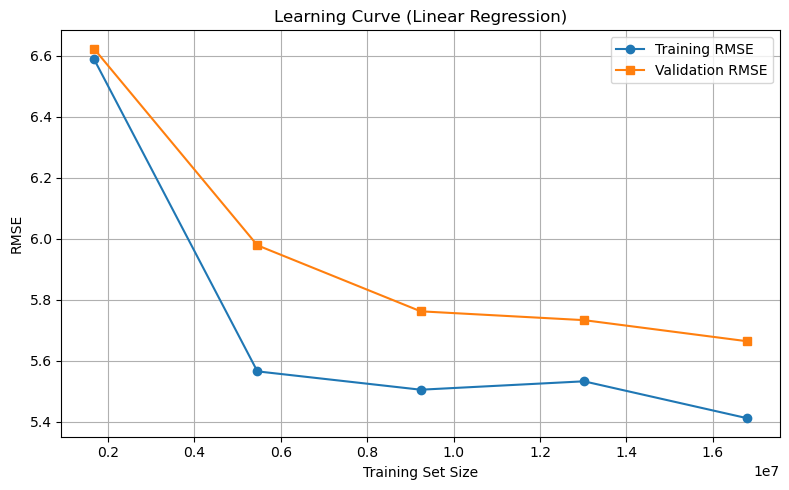

In [40]:
# Use RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,       # your features
    y=y,       # your target (e.g. tip_percentage)
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)

# Convert negative scores back to positive RMSE
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, label='Training RMSE', marker='o')
plt.plot(train_sizes, val_rmse, label='Validation RMSE', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [183]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(coef_df)


               Feature  Coefficient
12              tipped    10.065554
4            taxi_type    -0.762939
7        trip_distance    -0.404416
9        trip_duration    -0.249288
13  income_interaction     0.219563
8          fare_amount    -0.201729
11       fare_per_mile     0.113053
10           day_night    -0.072363
5   PU_income_quartile    -0.071933
2       DO_day_of_week    -0.064014
6   DO_income_quartile    -0.048827
3              DO_hour     0.030293
0       PU_day_of_week     0.026968
1              PU_hour    -0.012252


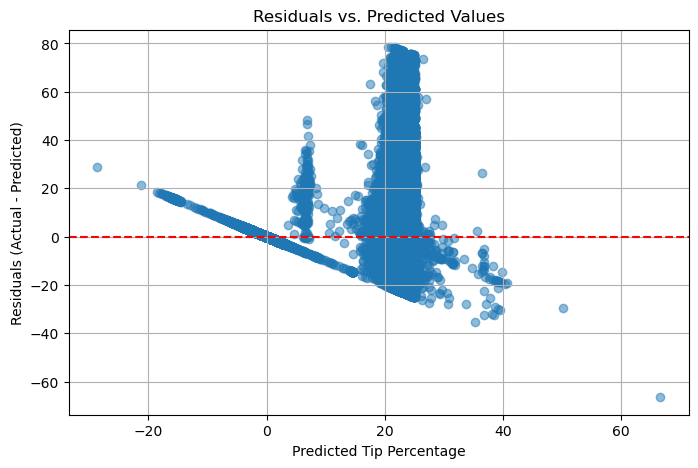

In [108]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Tip Percentage")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


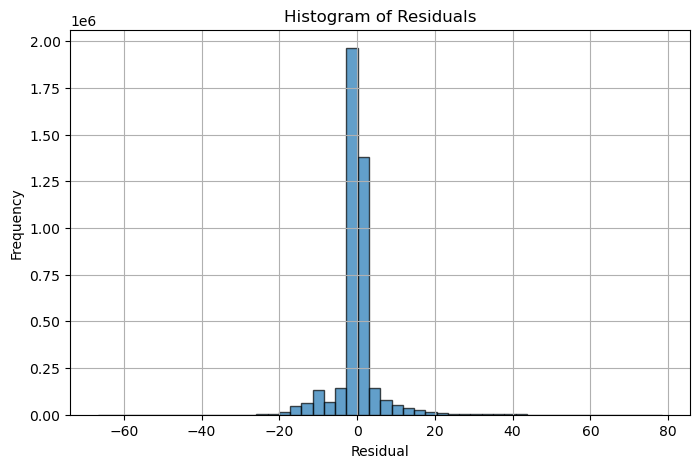

In [109]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [74]:
#pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [99]:
# Resetting X and y bc Light GBM doesn't accepted scaling
X = df[['PU_month', 'PU_day_of_week', 'PU_hour', 'DO_month', 'DO_day_of_week', 'DO_hour', 'taxi_type', 'PU_income_quartile', 'DO_income_quartile', 
        'trip_distance', 'fare_amount', 'trip_duration', 'day_night', 'fare_per_mile', 'tipped', 'income_interaction']]
y = df['tip_percentage']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X shape: (21005543, 16)
y shape: (21005543,)
          PU_month  PU_day_of_week  PU_hour  DO_month  DO_day_of_week  \
0                3               2       14         3               2   
1                3               2       14         3               2   
2                3               2       14         3               2   
3                3               2       18         3               2   
4                3               2       20         3               2   
...            ...             ...      ...       ...             ...   
21061061        12               7       23        12               7   
21061062        12               7       23        12               7   
21061063        12               7       23        12               7   
21061064        12               7       23        12               7   
21061065        12               7       23        12               1   

          DO_hour  taxi_type  PU_income_quartile  DO_income_quartile  \
0     

In [100]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    n_jobs=-1,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Adjusted R²
n = len(y_test)               # number of samples
p = X_test.shape[1]           # number of predictors/features
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R² Score: {adjusted_r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 16804434, number of used features: 16
[LightGBM] [Info] Start training from score 6.700271
Mean Squared Error (MSE): 192.4377
Root Mean Squared Error (RMSE): 13.8722
Mean Absolute Error (MAE): 1.9901
R² Score: -0.1848
Adjusted R² Score: -0.1848


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

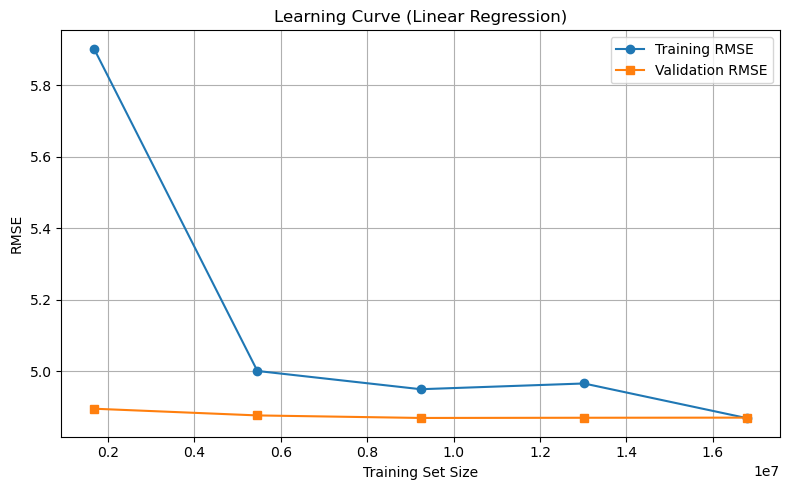

In [53]:
# Use RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lgb_model,
    X=X,       # your features
    y=y,       # your target (e.g. tip_percentage)
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1
)

# Convert negative scores back to positive RMSE
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, label='Training RMSE', marker='o')
plt.plot(train_sizes, val_rmse, label='Validation RMSE', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


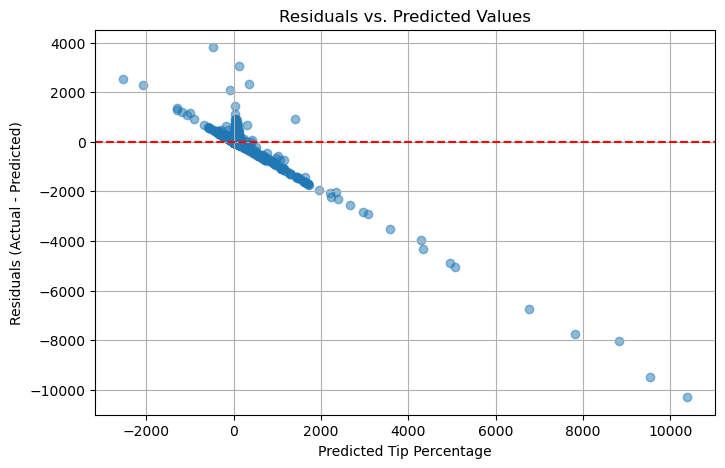

In [108]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Tip Percentage")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


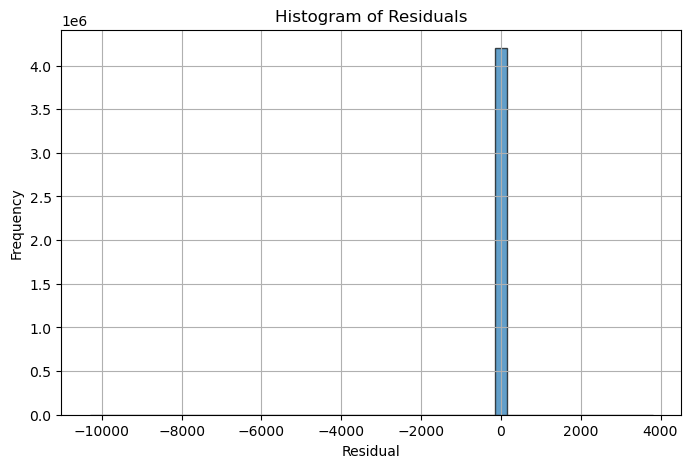

In [109]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


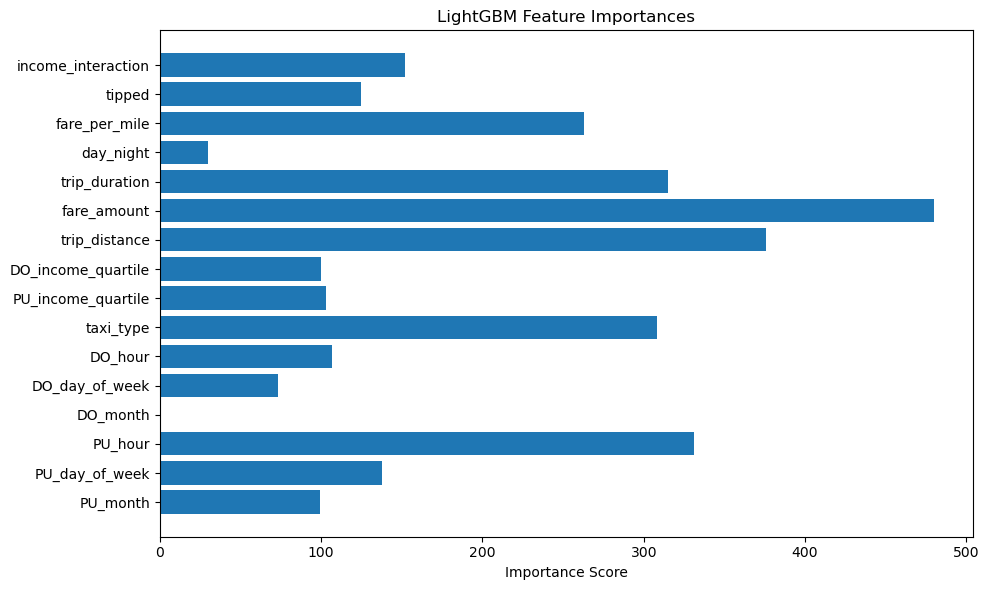

In [57]:
importances = lgb_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [162]:
#pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.9/546.9 kB 8.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Step 2: Setup SHAP for Your Model

In [61]:
import shap

# Initialize the SHAP explainer for LightGBM
explainer = shap.Explainer(lgb_model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1113
[LightGBM] [Info] Number of data points in the train set: 1679649, number of used features: 14
[LightGBM] [Info] Start training from score 11.507176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.200476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 9238072, number of used features: 16
[LightGBM] [Info] Start training from score 6.877464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

#### Step 3: Global Interpretation (Feature Importance)

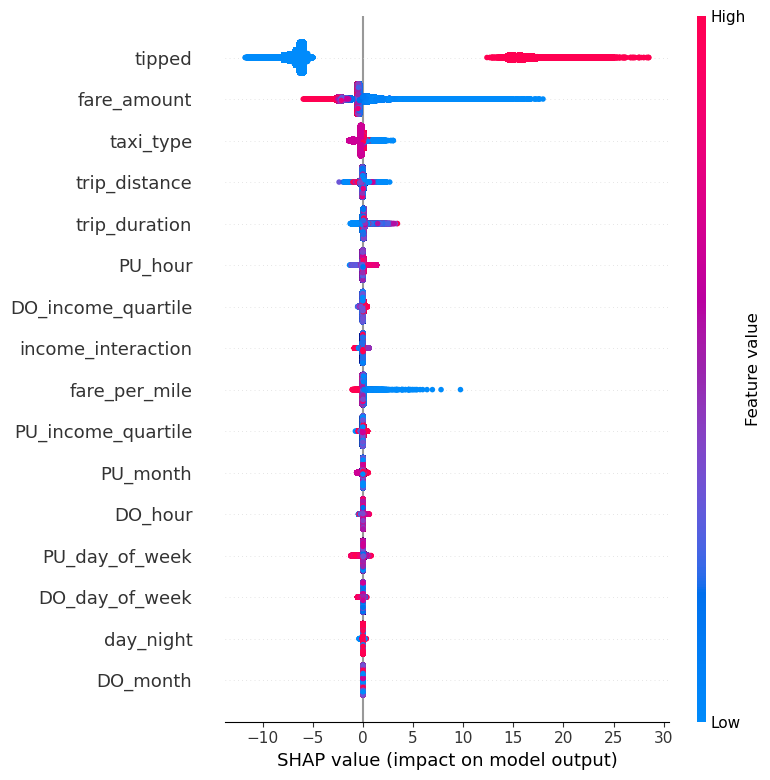

In [63]:
# Summary plot (beeswarm — shows impact and direction):
shap.summary_plot(shap_values, X_test)

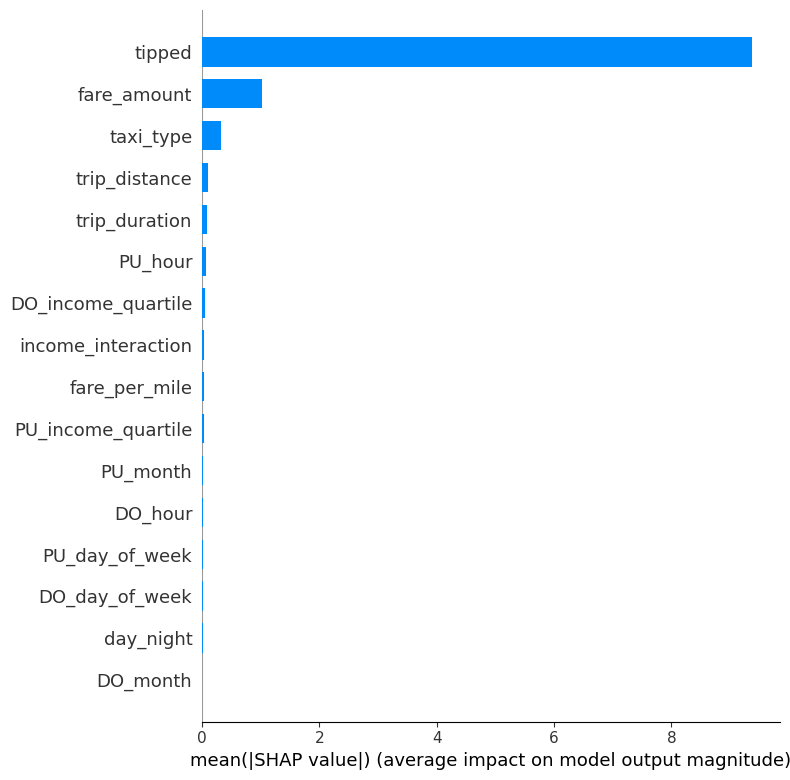

In [64]:
# Bar plot of mean absolute SHAP values:
shap.summary_plot(shap_values, X_test, plot_type="bar")

#### Step 4: Local Interpretation (Single Prediction)

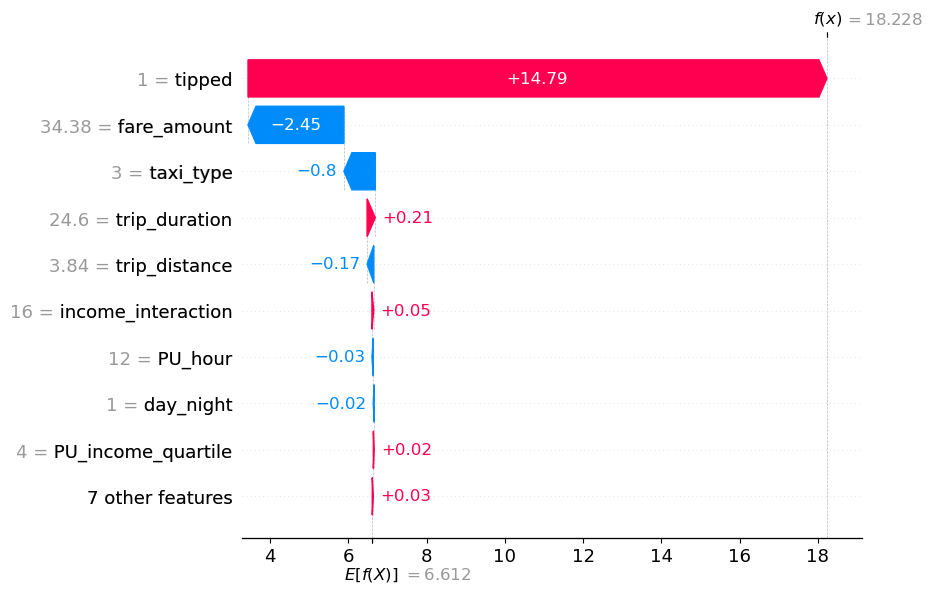

In [66]:
# Pick one instance (e.g., index 0)
shap.plots.waterfall(shap_values[0])

#### Force plot (Interactive)

In [72]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0])

In [42]:
over_100_df_f = over_100_df[over_100_df['tip_percentage'] < 1000]

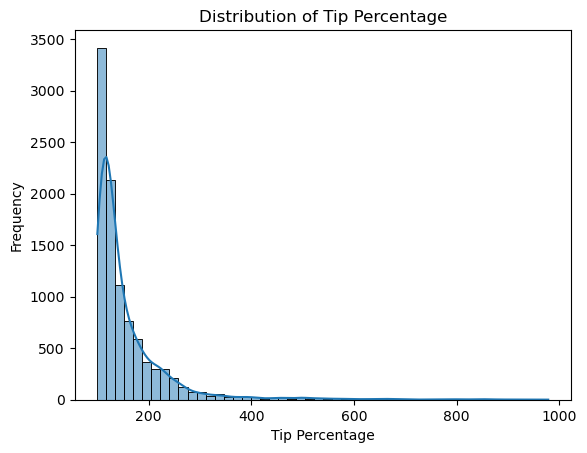

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(over_100_df_f['tip_percentage'], bins=50, kde=True)
plt.title('Distribution of Tip Percentage')
plt.xlabel('Tip Percentage')
plt.ylabel('Frequency')
plt.show()


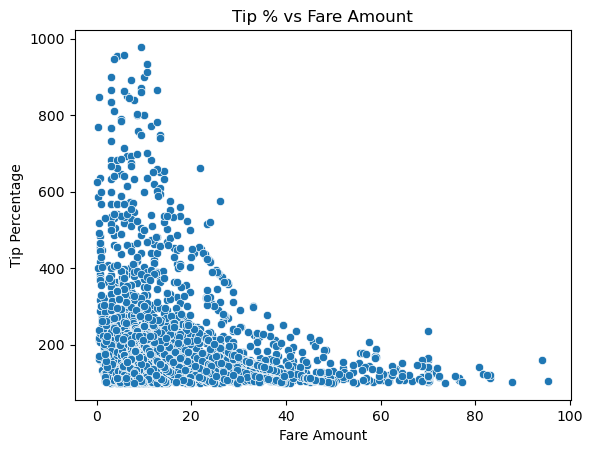

In [47]:
sns.scatterplot(data=over_100_df_f, x='fare_amount', y='tip_percentage')
plt.title('Tip % vs Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Tip Percentage')
plt.show()


In [20]:
print(over_100_df[['fare_amount', 'tip_percentage']].describe())
print(over_100_df[['fare_amount', 'tip_percentage']].isnull().sum())

       fare_amount  tip_percentage
count  9923.000000     9923.000000
mean     13.346848      189.206726
std      10.629307     2036.404947
min       0.010000      100.100000
25%       7.670000      112.360000
50%       9.620000      128.530000
75%      15.820000      171.070000
max      95.400000   201500.000000
fare_amount       0
tip_percentage    0
dtype: int64


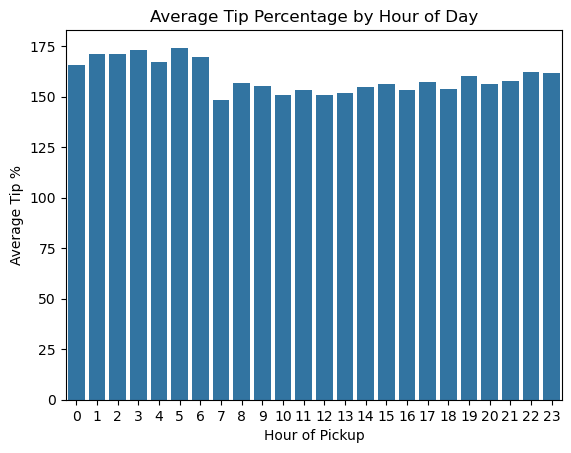

In [45]:
hourly_tip = over_100_df_f.groupby('PU_hour')['tip_percentage'].mean().reset_index()

sns.barplot(data=hourly_tip, x='PU_hour', y='tip_percentage')
plt.title('Average Tip Percentage by Hour of Day')
plt.xlabel('Hour of Pickup')
plt.ylabel('Average Tip %')
plt.xticks(range(0, 24))
plt.show()

C:\Users\kima\AppData\Local\Temp\ipykernel_18352\537643597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_100_df['day_name'] = over_100_df['PU_day_of_week'].map(dow_map)


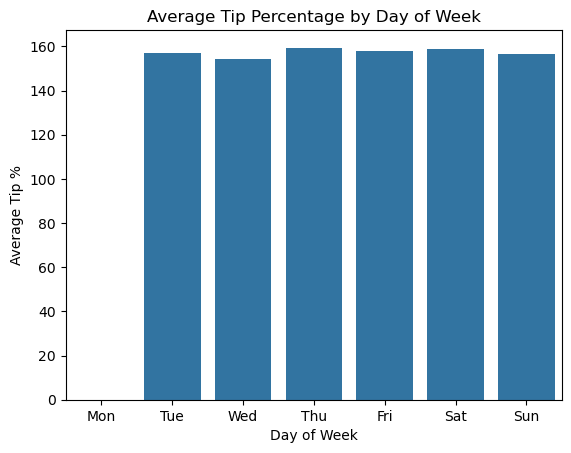

In [46]:
dow_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
over_100_df['day_name'] = over_100_df['PU_day_of_week'].map(dow_map)

daily_tip = over_100_df_f.groupby('day_name')['tip_percentage'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).reset_index()

sns.barplot(data=daily_tip, x='day_name', y='tip_percentage')
plt.title('Average Tip Percentage by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Tip %')
plt.show()

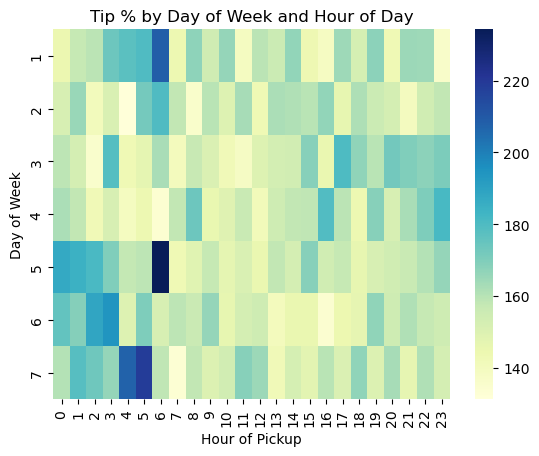

In [49]:
pivot_table = over_100_df_f.pivot_table(
    values='tip_percentage',
    index='PU_day_of_week',
    columns='PU_hour',
    aggfunc='mean'
)

pivot_table = pivot_table.reindex([1, 2, 3, 4, 5, 6,7])  # Ensure correct order: Mon–Sun

sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Tip % by Day of Week and Hour of Day')
plt.xlabel('Hour of Pickup')
plt.ylabel('Day of Week')
plt.show()

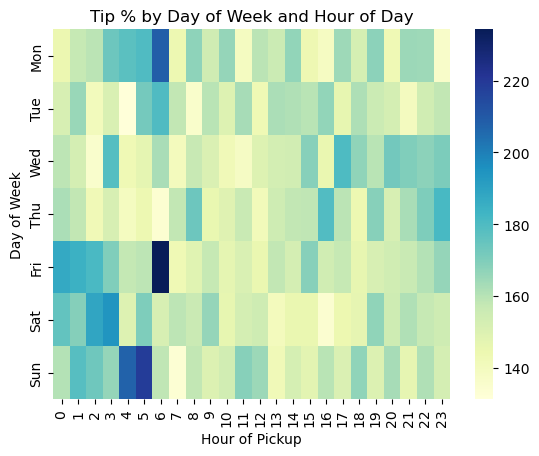

In [50]:
# Define a mapping for day of the week
dow_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

# Apply the mapping
pivot_table.index = pivot_table.index.map(dow_map)

sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Tip % by Day of Week and Hour of Day')
plt.xlabel('Hour of Pickup')
plt.ylabel('Day of Week')
plt.show()

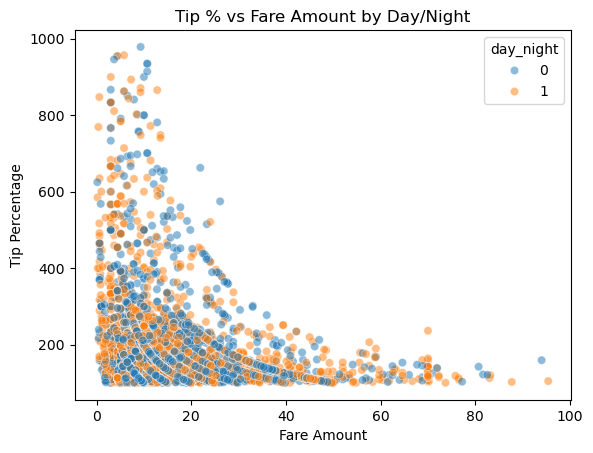

In [51]:
sns.scatterplot(data=over_100_df_f, x='fare_amount', y='tip_percentage', hue='day_night', alpha=0.5)
plt.title('Tip % vs Fare Amount by Day/Night')
plt.xlabel('Fare Amount')
plt.ylabel('Tip Percentage')
plt.show()

In [41]:
over_300_count = (over_100_df['tip_percentage'] > 1000).sum()
print(f"Number of rows with tip percentage > 300%: {over_300_count}")

Number of rows with tip percentage > 300%: 46


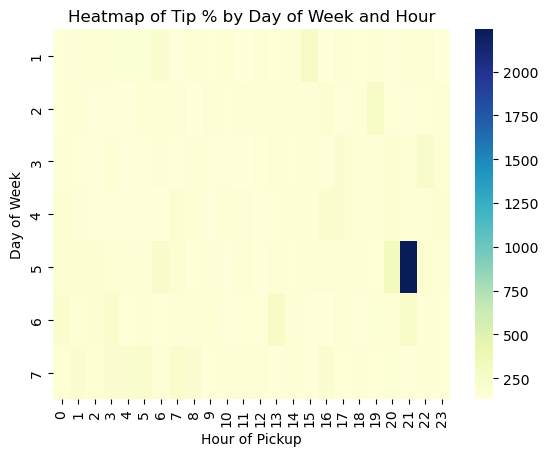

In [36]:
heatmap_df = over_100_df.pivot_table(index='PU_day_of_week', columns='PU_hour', values='tip_percentage', aggfunc='mean')

sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('Heatmap of Tip % by Day of Week and Hour')
plt.xlabel('Hour of Pickup')
plt.ylabel('Day of Week')
plt.show()

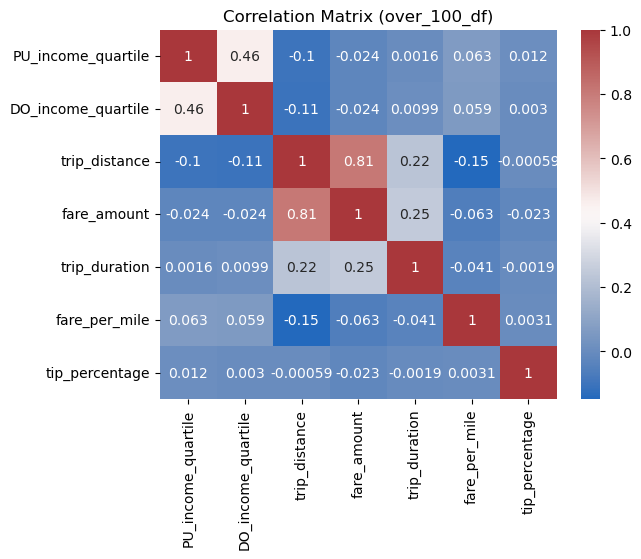

In [37]:
import seaborn as sns

features = ['PU_income_quartile', 'DO_income_quartile', 'trip_distance', 'fare_amount', 
            'trip_duration', 'fare_per_mile', 'tip_percentage']
sns.heatmap(over_100_df[features].corr(), annot=True, cmap='vlag')
plt.title('Correlation Matrix (over_100_df)')
plt.show()